# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I = \varepsilon \int_{M_0}^{M_f} \mathbf{G}(I,M) \, u \ \textrm{d} M, \quad u \in \mathcal{U}$$

$$ \delta I (M_0) = 0, \quad \delta I (M_f) \parallel \mathbf{b}, $$

$$ \left( \delta I (M_f) \, | \, \mathbf{b} \right) \longrightarrow \max, $$

$$ M_0 = 0; M_f = 2 \pi $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{b}$. 

[Thumbnail](solarsail.jpeg)

## Initializations

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from scipy.linalg import null_space
from gve import *
from os import system

# Definition of optical parameters 
rho     = 0.6         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 0.          # 0 for triangular cone, 1 for real drop 
mu      = 1.
sDir    = np.array([0., 0., -1.])

# Initial guess of pI taken from the convex program approximation 
pI         = np.array([-0.1492,  -0.2744,  -0.1004,  -0.2594,  1.0000])
M1_guess   = 0.8762
M2_guess   = 5.3809
I1_guess   = np.array([-0.6552,  0.1258,  0.4852,  -0.0240,  0.0263])
I2_guess   = np.array([-0.6543,  0.1304,  0.4841,  -0.0274,  0.0267])
z          = np.hstack((pI, M1_guess, M2_guess, I1_guess, I2_guess))
   
def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y

# Initial state

I       = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.6])                         # Initial state
d       = np.array([ 0.,  0.,  0.,  0.,  1.])                                               # Direction of the displacement
I0      = np.array([0., 0., 0., 0., 0])                                                     # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])

pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

## Hamiltonian

In [3]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

In [4]:
from hfun     import hfun     
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 

hfun_u   = lambda M, q, p, cont                   : hfun.hfun_u(M, q, p, pars, cont)
ufun     = lambda M, q, p, cont                   : hfun.control(M, q, p, pars, cont) 
dhfun_u  = lambda M, q, dq, p, dp, cont           : hfun_d.hfun_u_d(M, q, dq, p, dp, pars, cont)
d2hfun_u = lambda M, q, dq, d2q, p, dp, d2p, cont : hfun_d_d.hfun_u_d_d(M, q, dq, d2q, p, dp, d2p, pars, cont)

In [5]:
def dhfun_0(M, q, dq, p, dp, cont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, q, dq, d2q, p, dp, d2p, cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, cont):
    h = 0.0
    return h

In [6]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(2, 3), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(2, 3), full=True)(hfun_0)
ufun        = tools.vectorize(vvars=(1,2,3))(ufun)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Shooting function

In [7]:
def dshoot(z, dz, pars, d, d_orth, cont, next=False):
    I0  = np.zeros(5)
    M0  = 0.
    Mf  = 2. * np.pi

    pI  = z[0 : 5]
    M1  = z[5]
    M2  = z[6]
    I1  = z[7 : 12]
    I2  = z[12 : 17]

    dpI = dz[0 : 5]
    dM1 = dz[5]
    dM2 = dz[6]
    dI1 = dz[7 : 12]
    dI2 = dz[12 : 17]

    #----------------------------------
    (I1sol, dI1sol), (pI1, dpI1) = fu(M0, I0, (pI, dpI), (M1, dM1), cont)
    (I2sol, dI2sol), (pI2, dpI2) = f0((M1, dM1), (I1, dI1), (pI, dpI), (M2, dM2), cont)
    (If, dIf), (pIf, dpIf)       = fu((M2, dM2), (I2, dI2), (pI, dpI), Mf, cont)

    #----------------------------------
    s           = np.zeros(17)
    s[0]        = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5]    = np.dot(d_orth, If)

    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    ds          = np.zeros(17)
    ds[0]       = dpIf[0] * d[0] + dpIf[1] * d[1] + dpIf[2] * d[2] + dpIf[3] * d[3] + dpIf[4] * d[4] 
    ds[1 : 5]   = np.dot(d_orth, dIf)

    ds[7 : 12]  = dI1 - dI1sol
    ds[12 : 17] = dI2 - dI2sol

    s[5], ds[5] = Hu((M1, dM1), (I1, dI1), (pI, dpI), cont) #- H0((M1, dM1), (I1, dI1), (pI, dpI), pars, cont)
    s[6], ds[6] = Hu((M2, dM2), (I2, dI2), (pI, dpI), cont) #- H0((M2, dM2), (I2, dI2), (pI, dpI), pars, cont)

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs entre 7 et 17 

    if not next: return s, ds
    else: return s, ds, (Mf, If, pIf, None)

#@tools.vectorize(vvars=(3,))
#@tools.vectorize(vvars=(4,), next=True)
@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    M1 = z[5]
    M2 = z[6]
    I1 = z[7 : 12]
    I2 = z[12 : 17]

    #----------------------------------
    I1sol, pI1 = fu(M0, I0, pI, M1, cont)
    I2sol, pI2 = f0(M1, I1, pI, M2, cont)
    If, pIf    = fu(M2, I2, pI, Mf, cont)

    #----------------------------------
    s        = np.zeros(17)
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)

    # theta1            = atan2(pI1*sPerp/(pI1*sDir))
    # theta2            = atan2(pI2*sPerp/(pI2*sDir))
    # s[5]                      = theta1 - cone_alpha - deg2rad(90.)
    # s[6]                      = theta2 - cone_alpha - deg2rad(90.)

    s[5]        = Hu(M1, I1, pI, cont)
    s[6]        = Hu(M2, I2, pI, cont)
    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs

    if not next: return s
    else: return s, (Mf, If, pIf, None)

In [8]:
@tools.vectorize(vvars =(1,))
def control(M, I, pI, cont):
    sol  = np.array([0., 0., 0.])
    if type(M)==int:
        if Hu(M, I, pI, cont) < 0.:
            sol = np.array([0., 0., 0.])
        else: 
            sol = ufun(M, I, pI, cont)
    else:
        for ii in range(len(M)):
            if Hu(M[ii], I, pI, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M, I, pI, cont)))   
        sol = np.delete(sol, 0, 0)
    return sol

## Solve

In [9]:
dfoo = lambda z, dz: shoot((z, dz), pars, d, d_orth, cont) 
foo = lambda z: shoot(z, pars, d, d_orth, cont)
foo = tools.tensorize(dfoo, full=True)(foo)

In [10]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8) 
et = time.time(); sol = nle.solve(foo, z, df=foo, options=nleopt); 
#et = time.time(); sol = nle.solve(foo, z, options=nleopt); 


     Calls  |f(x)|                 |x|
 
         1  3.743762127548254e-02  5.679741568944841e+00
         2  3.647127366337665e-01  5.703700186586675e+00
         3  7.368564703799946e-03  5.697039803014532e+00
         4  4.560564959298058e-03  5.697138905470806e+00
         5  1.018724025111750e-03  5.696913229416578e+00
         6  1.077101295418109e-04  5.696896765534927e+00
         7  2.060464582968516e-05  5.696897723610324e+00
         8  1.777624684428049e-06  5.696897918031528e+00
         9  7.215409372574669e-08  5.696897909916546e+00
        10  4.861157378413444e-09  5.696897910647910e+00
        11  1.117322975115211e-10  5.696897910690251e+00

 Results of the nle solver method:

 xsol    =  [-0.15103251 -0.27644037 -0.10297985 -0.25967058  1.          0.87252303
  5.39636499 -0.66324281  0.13052591  0.48922474 -0.02645175  0.02639506
 -0.66324281  0.13052591  0.48922474 -0.02645175  0.02639506]
 f(xsol) =  [ 0.00000000e+00 -1.97421246e-12 -7.47819012e-11  6.78096078e-

In [11]:
z_sol = sol.x; et = time.time() - et
print('Elapsed time:', et)
#print('z_sol =', z_sol)
#print('foo =', foo(z_sol))

Elapsed time: 4.018569469451904


In [12]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
I1         = z_sol[7 : 12]
I2         = z_sol[12 : 17]
u          = control(M0, I0, pI, cont)

## Function of continuous integration

In [13]:
def plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, nOrb):

    N       = 20
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    I       = np.array([0., 0., 0., 0., 0]) 
    I0      = np.array([0., 0., 0., 0., 0]) 
    M0      = 0
    M0_2_M1 = np.linspace(M0, M1, N+1)
    M1_2_M2 = np.linspace(M1, M2, N+1)
    M2_2_Mf = np.linspace(M2, Mf, N+1)
    u_vect  = np.array([0., 0., 0.])
        
    for ii in range(nOrb):
        Mspan1  = list((ii)*2*np.pi*np.ones(N+1)+M0_2_M1)
        Mspan2  = list((ii)*2*np.pi*np.ones(N+1)+M1_2_M2)
        Mspanf  = list((ii)*2*np.pi*np.ones(N+1)+M2_2_Mf)
        
        I1sol, pI1sol = fu(M0, I0, pI, Mspan1, cont)  # on [ 0, t1]
        I2sol, pI2sol = f0(Mspan1[-1], I1sol[-1], pI, Mspan2, cont)  # on [t1, t2]
        Ifsol, pIfsol = fu(Mspan2[-1], I2sol[-1], pI, Mspanf, cont)  # on [t2, tf]
        
        M_vect        = np.hstack((M_vect, Mspan1, Mspan2, Mspanf))  
        
        for kk in range(N+1):
            val           = I1sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = I2sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = Ifsol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        I0            = Ifsol[-1]
        M0            = Mspanf[-1]
    
    u_vect = control(M_vect, I, pI, cont)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    ang1   = np.arccos(u_s/np.linalg.norm(u_vect,axis=1))
    where_are_NaNs = np.isnan(ang1)
    ang1[where_are_NaNs] = 0
    ang1   = rad2deg(ang1)
    
    ang2   = np.arctan2(u_3 ** 2, u_2 ** 2)
    ang2   = rad2deg(ang2)

    M_vect = M_vect/(2*np.pi)
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1, linewidth=2); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2, linewidth=2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3, linewidth=2); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a, linewidth=2); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e, linewidth=2); 
    #ax6  = fig.add_subplot(426); 
    #ax6.plot(M_vect, u_s); 
    ax7  = fig.add_subplot(427); 
    ax7.plot(M_vect, ang1); 
    ax8  = fig.add_subplot(428); 
    ax8.plot(M_vect, ang2); 

    
    ax1.set_xlabel('$Orbit $'); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel('$Orbit $'); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel('$Orbit $'); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel('$Orbit $'); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel('$Orbit $'); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    #ax6.set_xlabel('$Orbit \, number$'); ax6.set_ylabel('$u_s$');      ax6.axhline(0, color='k')
    ax7.set_xlabel('$Orbit $'); ax7.set_ylabel('$Cone \ ang1$');      ax7.axhline(0, color='k')
    ax8.set_xlabel('$Orbit $'); ax8.set_ylabel('$Cone \ ang2$');      ax8.axhline(0, color='k')
    #ax9.set_xlabel('$Orbit \, number$'); ax9.set_ylabel('$u_4$');      ax9.axhline(0, color='k')


## Plots

In [14]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
I1         = z_sol[7 : 12]
I2         = z_sol[12 : 17]

If, pI = fu(M2, I2, pI, 2*np.pi, cont)

### One orbit

/home/caillau/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


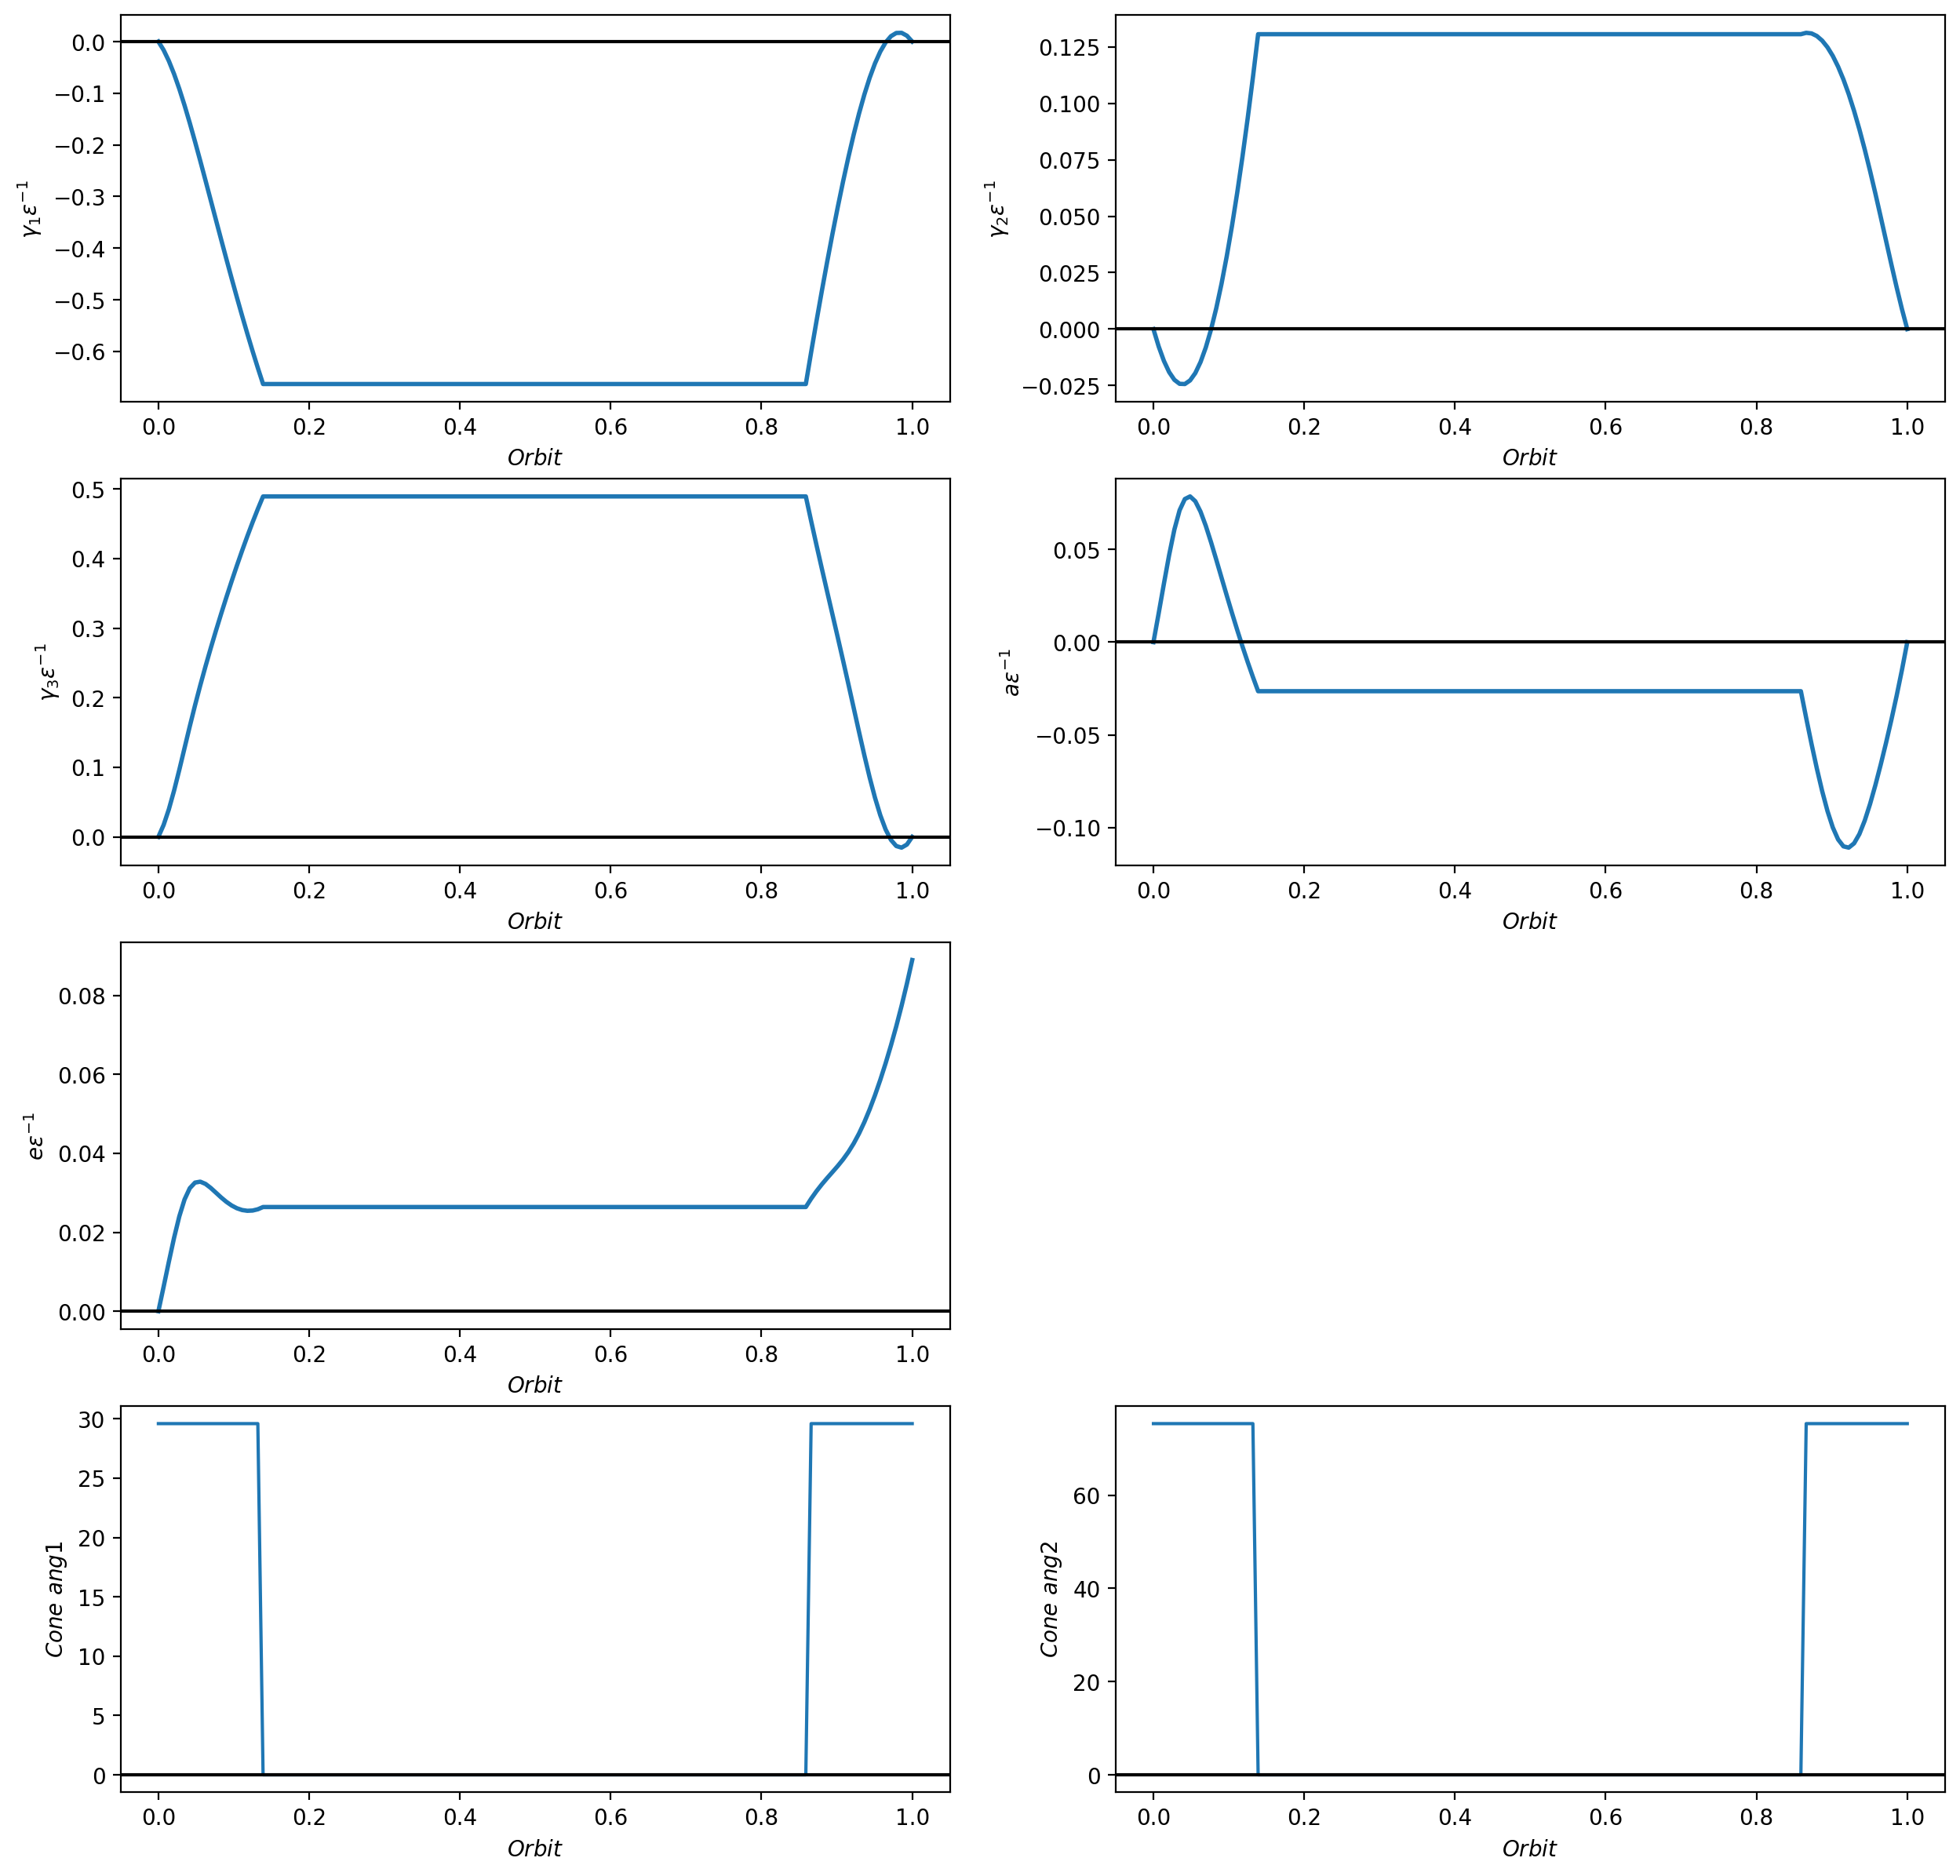

In [15]:
plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, 1)

### Multiple orbits

/home/caillau/.conda/envs/ct-gallery/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


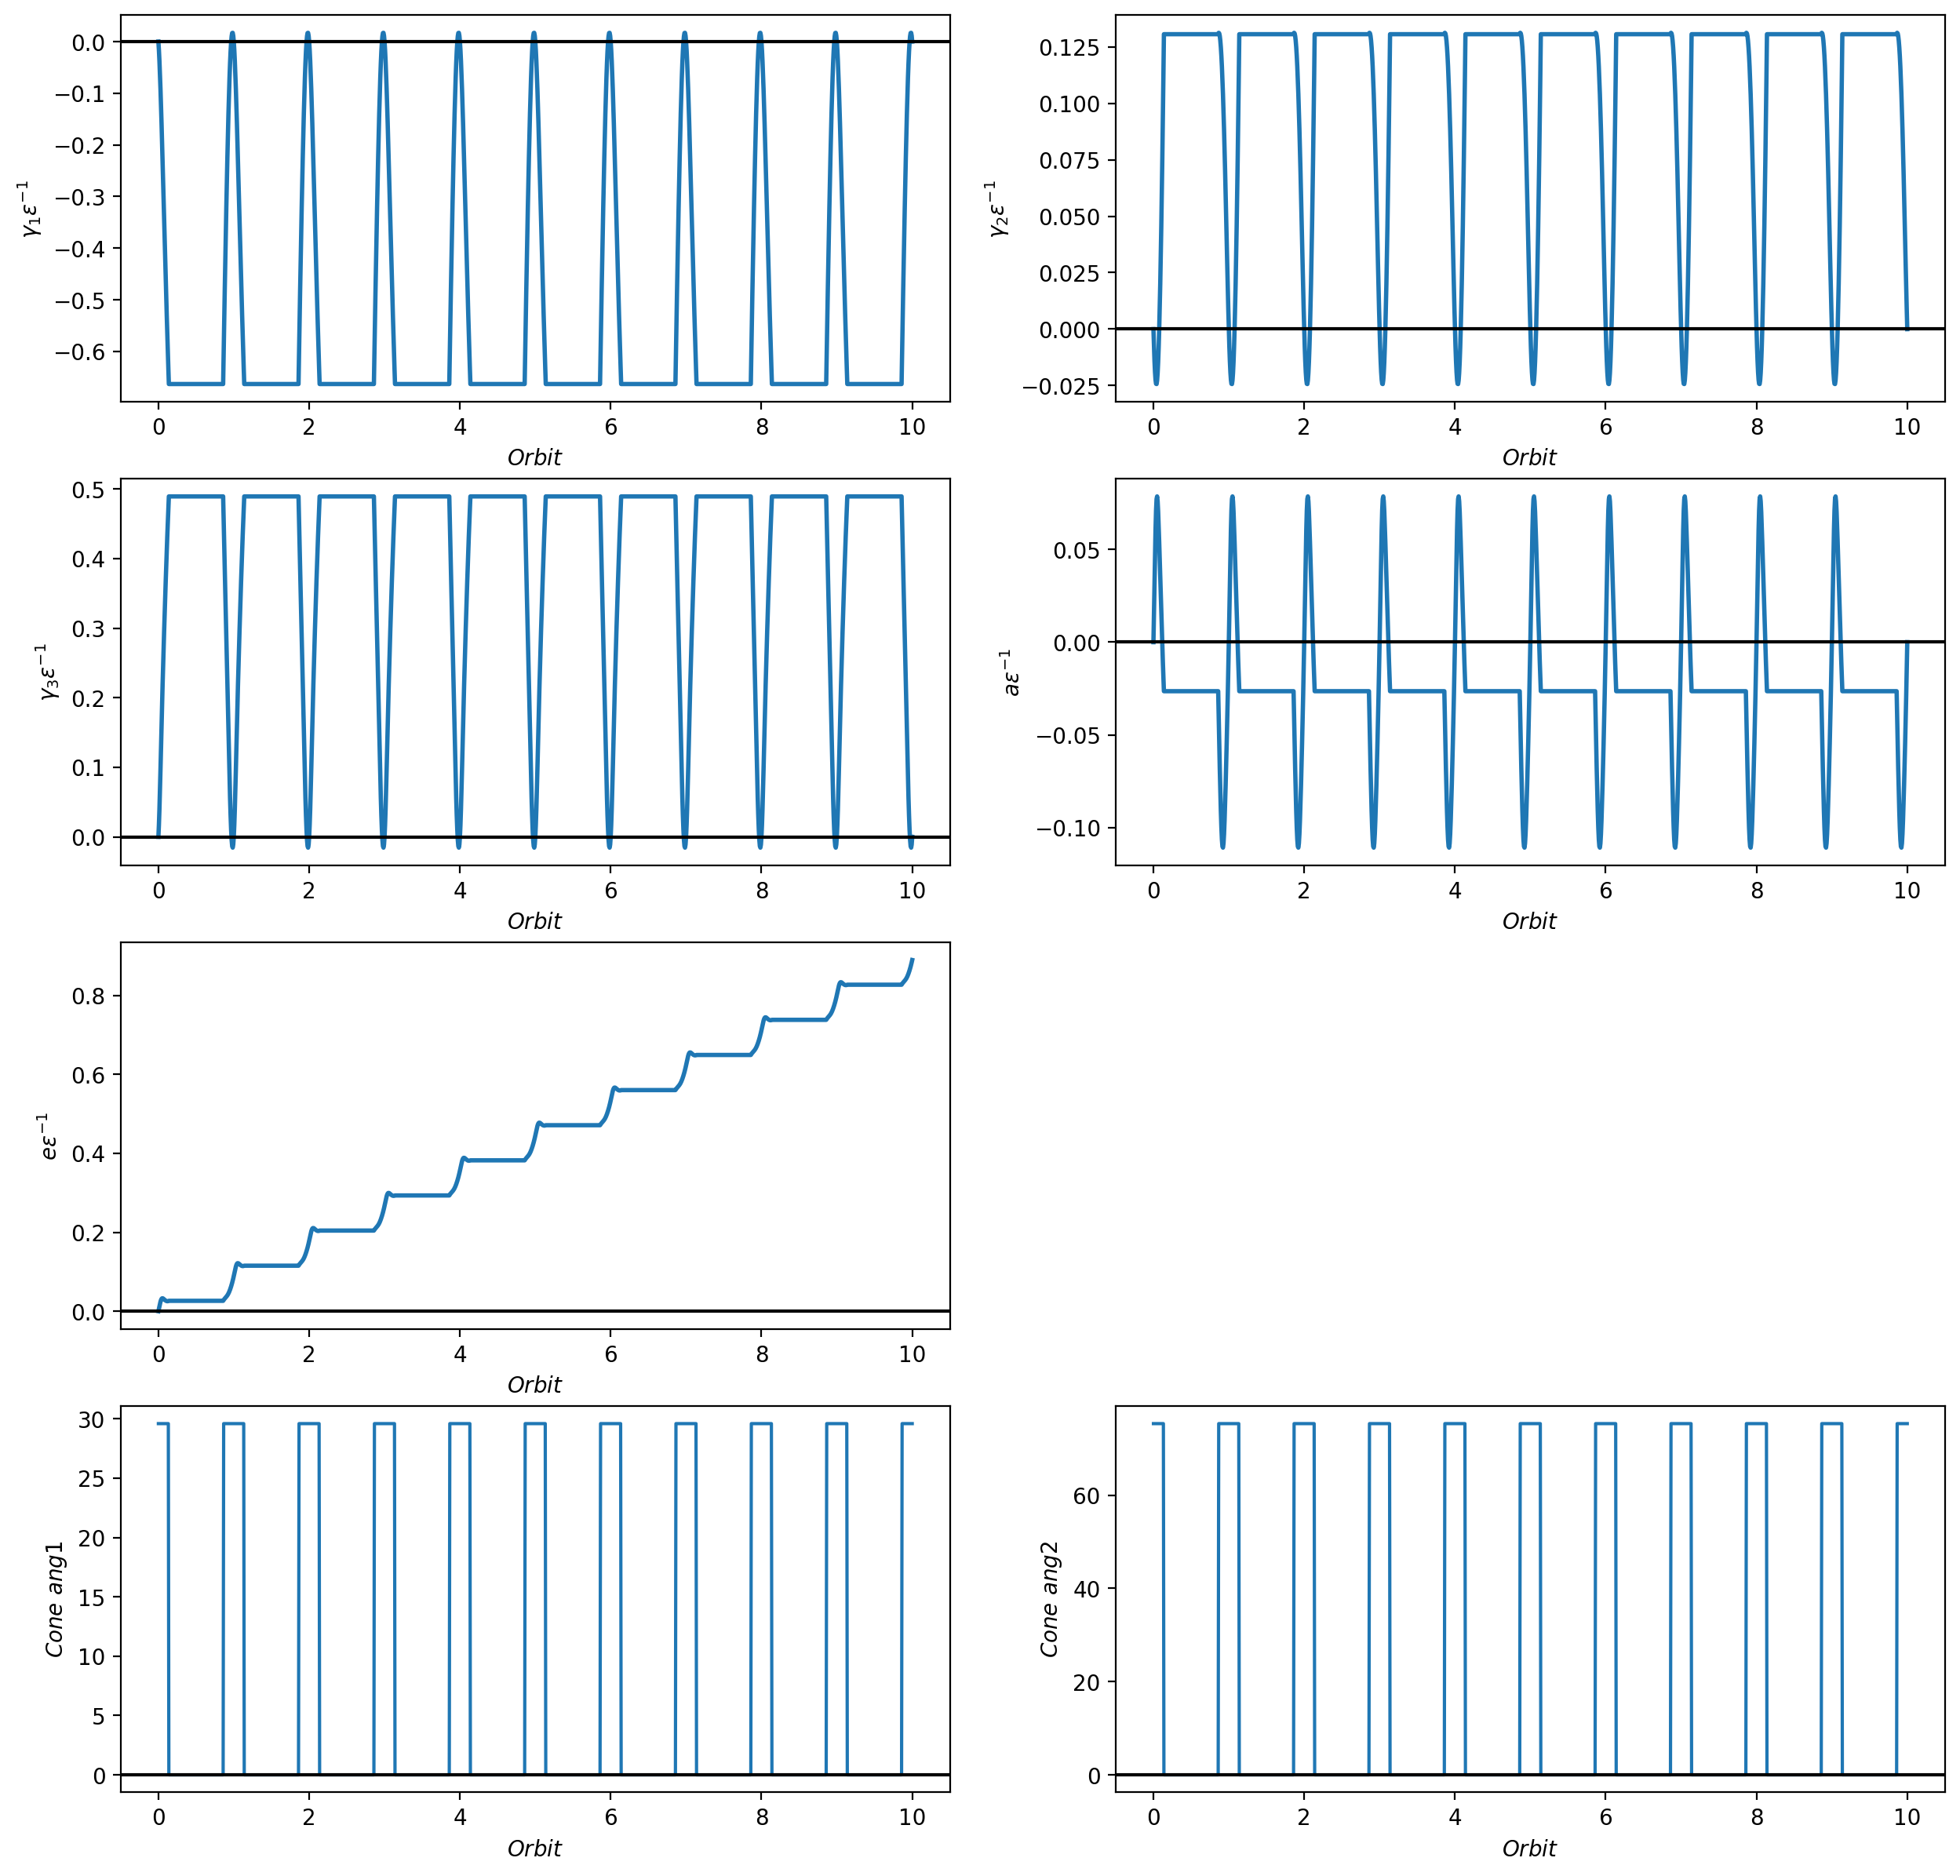

In [16]:
plotSolutionBSB(pI, M1, M2, Mf, sDir, cont, 10)